In [1]:
from utils import CustomDataset, transform, preproc, Convert_ONNX
from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
from resnet_model_mask import  ResidualBlock, ResNet
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm 
import torch.nn.functional as F
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pickle

torch.manual_seed(1)
# torch.manual_seed(42)


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
num_gpus = torch.cuda.device_count()
print(num_gpus)

# Create custom dataset instance
data_dir = '/mnt/buf0/pma/frbnn/train_ready'
dataset = CustomDataset(data_dir, transform=transform)
valid_data_dir = '/mnt/buf0/pma/frbnn/valid_ready'
valid_dataset = CustomDataset(valid_data_dir, transform=transform)


num_classes = 2
trainloader = DataLoader(dataset, batch_size=420, shuffle=True, num_workers=32)

model = ResNet(24, ResidualBlock, [3, 4, 6, 3], num_classes=num_classes).to(device)
model = nn.DataParallel(model)
model = model.to(device)
params = sum(p.numel() for p in model.parameters())
print("num params ",params)


6
num params encoder  50840
num params  21496282


In [2]:
# model_path = 'models/model-62-98.78.pt'
model_path = 'models/model-47-99.125.pt'

# model_path = 'models_mask/model-10-97.055_1.pt'
model.load_state_dict(torch.load(model_path, weights_only=True))
model = model.eval()

In [3]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
fil = r.FilReader('/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil')
header = fil.header
print(header)

Header(filename='/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil', data_type='raw data', nchans=192, foff=-0.5, fch1=1187.5, nbits=32, tsamp=6.4e-05, tstart=60692.03208333333, nsamples=28125184, nifs=1, coord=<SkyCoord (ICRS): (ra, dec) in deg
    (83.63322, 22.01446)>, azimuth=<Angle 80.54659271 deg>, zenith=<Angle 66.41192055 deg>, telescope='Effelsberg LOFAR', backend='FAKE', source='crab', frame='topocentric', ibeam=0, nbeams=2, dm=0, period=0, accel=0, signed=False, rawdatafile='', stream_info=StreamInfo(entries=[FileInfo(filename='/mnt/primary/ata/projects/p031/fil_60692_02772_253151611_crab_0001/LoA.C0736/fil_60692_02772_253151611_crab_0001-beam0000.fil', hdrlen=338, datalen=21600141312, nsamples=28125184, tstart=60692.03208333333, tsamp=6.4e-05)]))


  0%|                                                  | 0/4981 [00:00<?, ?it/s]/tmp/ipykernel_2733676/3952106934.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  out = model(transform(torch.tensor(data).cuda())[None])
 20%|███████▊                               | 1000/4981 [01:59<07:57,  8.34it/s]


5


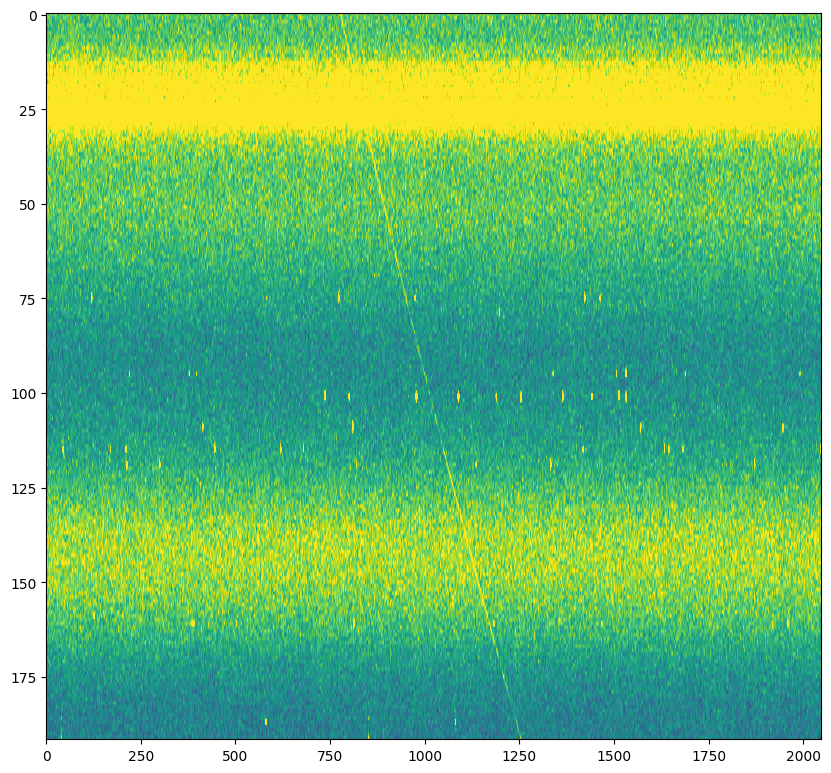

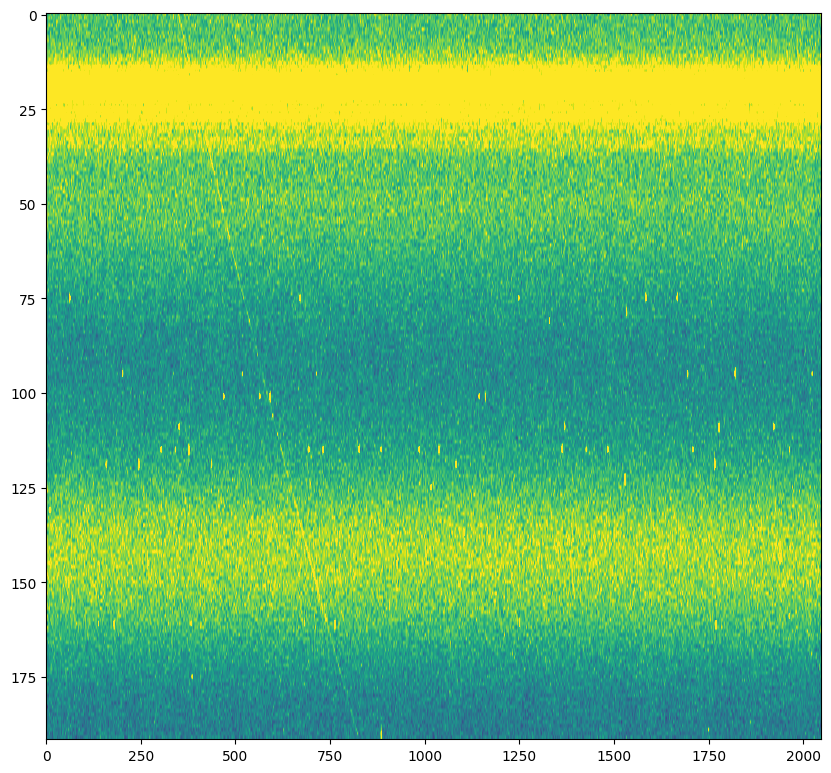

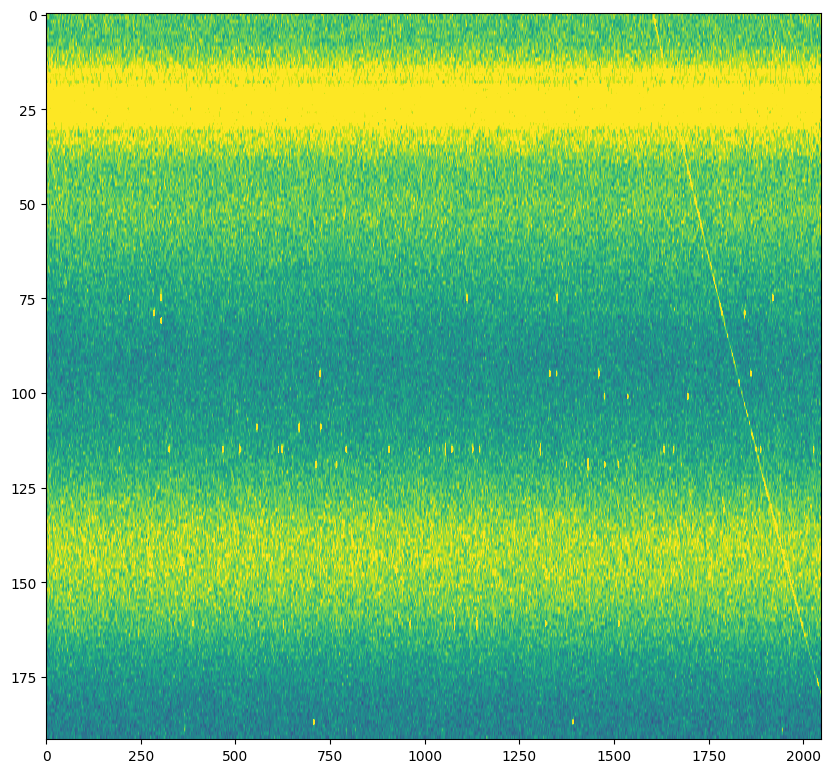

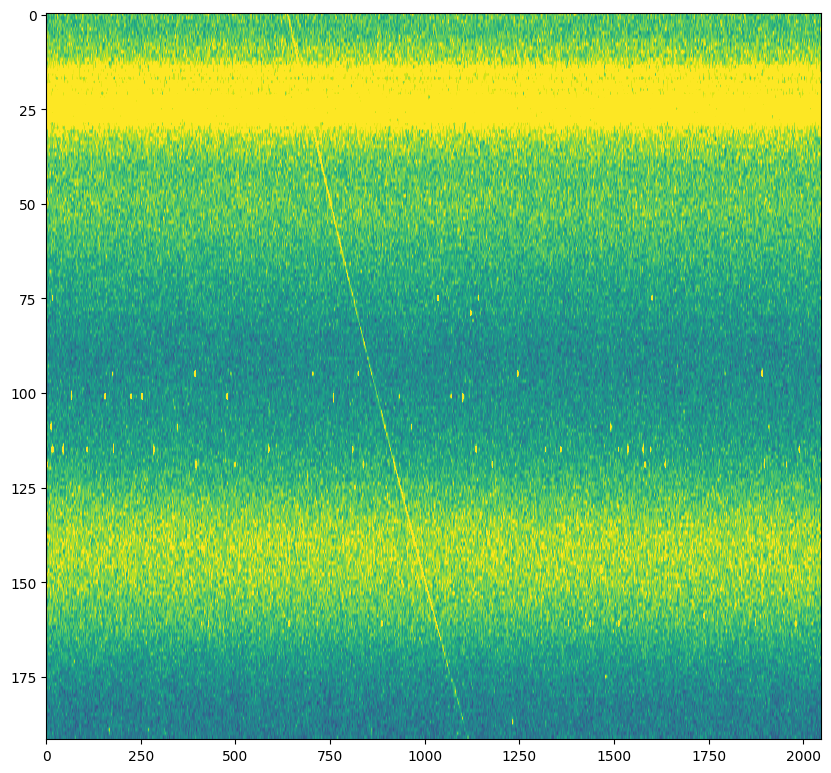

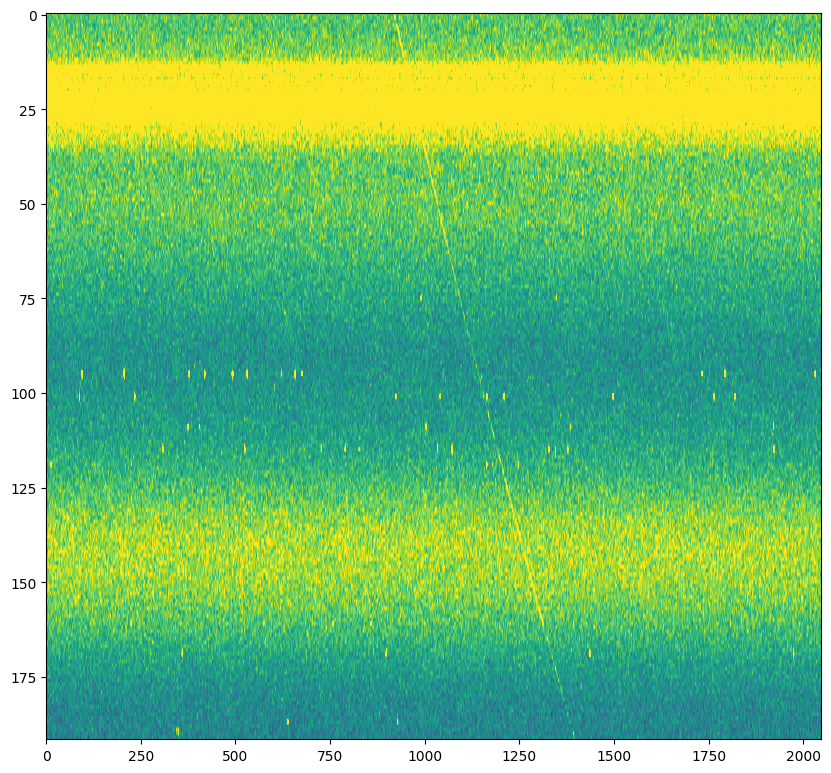

In [13]:
import sigpyproc.readers as r
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import softmax
from tqdm import tqdm
%matplotlib inline

header = fil.header
triggers = []
counter = 0
for i in tqdm(range(2048,10201921, 2048)):
    data = torch.tensor(fil.read_block(i-1024, 2048)).cuda()
    # Shuffle the tensor using the random indices
    out = model(transform(torch.tensor(data).cuda())[None])
    out = softmax(out.detach().cpu().numpy(), axis=1)
    triggers.append(out)
    counter += 1
    if counter > 1000:
        break
    if out[0, 1]>0.9982:
        key = data.cpu().numpy()
        plt.figure(figsize=(10,10))
        plt.imshow(data.cpu().numpy(), aspect = 10, vmax = 54557.824)
stack = np.stack(triggers)
positives = stack[:,0,1]
num_pos = np.where(positives > 0.9988)[0].shape[0]
print(num_pos)

In [11]:
key.mean()

44557.824

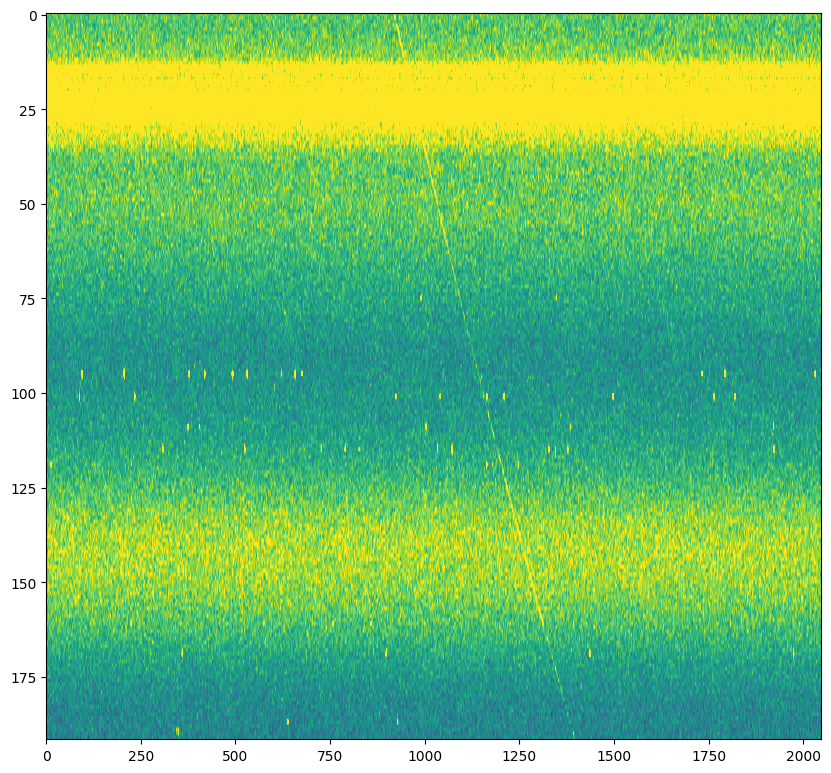

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(key, aspect = 10, vmax = 54557.824)

In [14]:
key.shape

(192, 2048)

In [27]:
total_data =[]
for i in range(32):
    total_data.append(key)
total_data = torch.tensor(np.array(total_data))
total_data.cpu().detach().numpy().tofile("crab_in.bin")
print(total_data.shape)
outputs_data = []
for i in range(32):
    temp = model(transform(total_data.cuda()[i,:,:])[None])
    print(temp)
    # outputs_data.append(softmax(temp.detach().cpu().numpy(), axis=1))
    outputs_data.append(softmax(temp.detach().cpu().numpy(), axis=1))
outputs_data = torch.tensor(outputs_data)
outputs_data.cpu().detach().numpy().tofile("crab_out.bin")


torch.Size([32, 192, 2048])
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-21.0018,  21.0959]], device='cuda:0', grad_fn=<GatherBackward>)
tensor([[-